In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reference:
- https://www.kaggle.com/code/sahilgarg108/hyperparameter-tuning-92-f1-auc-roc
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

In [ ]:
raw_df = pd.read_csv("/content/drive/MyDrive/Programming/Datasets/weatherAUS.csv")
raw_df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


# Look at the Big Picture

In [ ]:
raw_df.drop(columns=["Date"], inplace=True)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 non-null

In [ ]:
raw_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [ ]:
categorical_features = raw_df.select_dtypes(["object"]).columns.tolist()
numerical_features = raw_df.select_dtypes(["float64"]).columns.tolist()

print(f"Number of numerical independent features: {len(numerical_features)}")
print(f"Number of categorical independent features: {len(categorical_features)}")

Number of numerical independent features: 16
Number of categorical independent features: 6


In [ ]:
print(f"categorical features: {categorical_features}")
print(f"numerical features: {numerical_features}")

categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


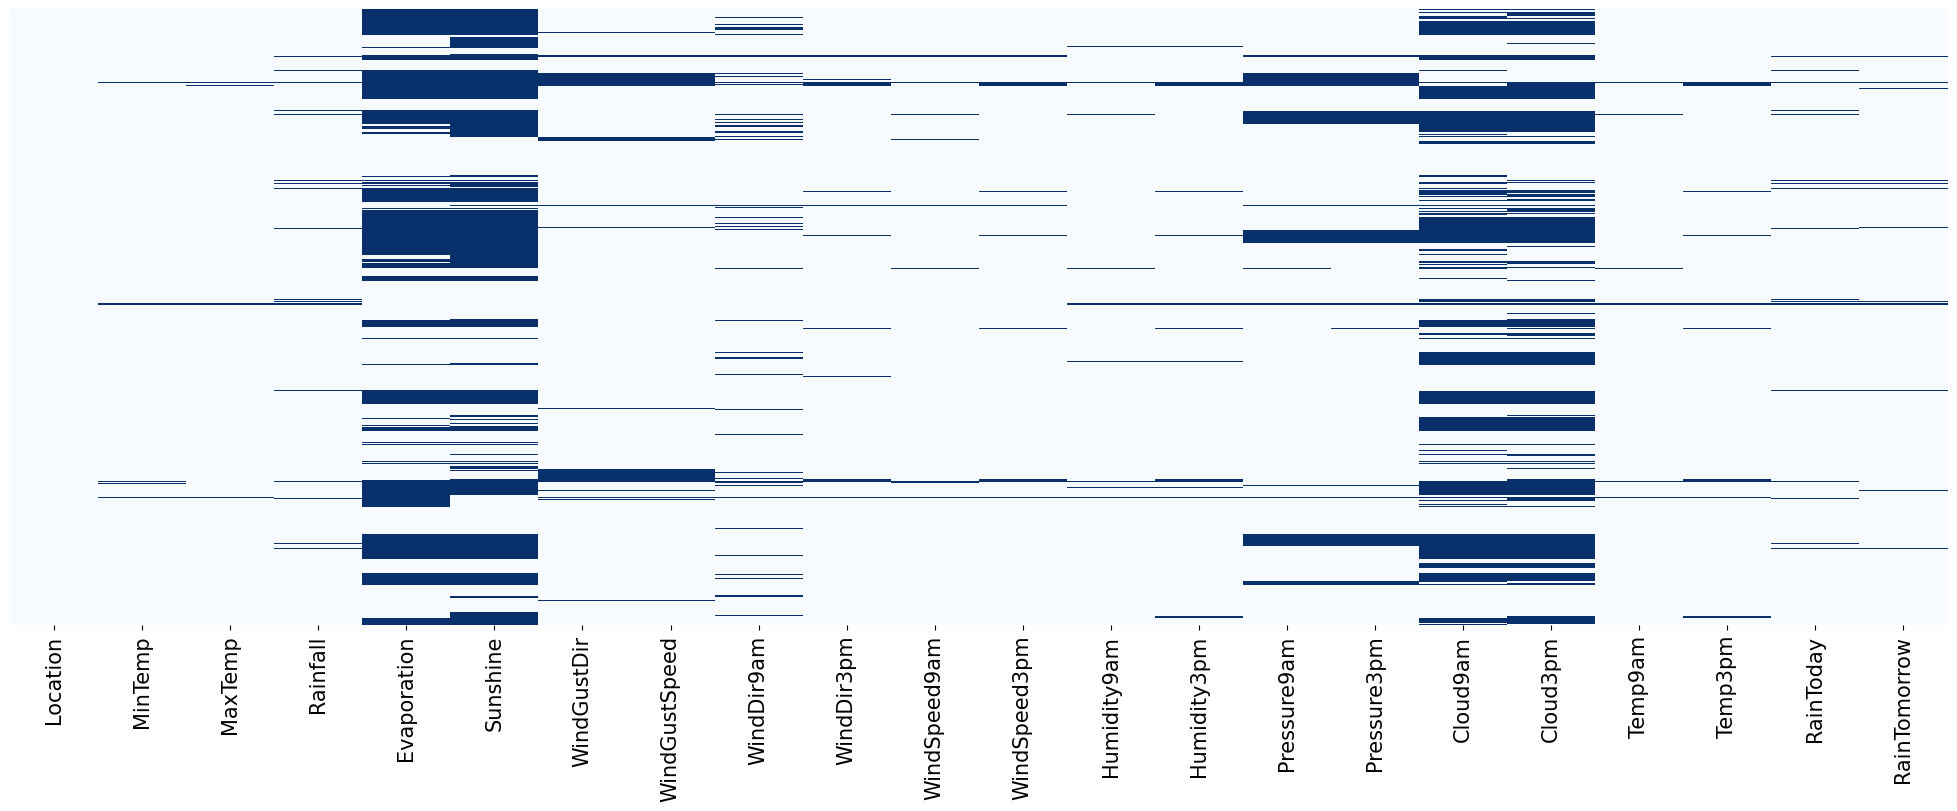

In [ ]:
plt.figure(figsize = (25,8))
sns.heatmap(raw_df.isnull(), cbar=False, cmap='Blues', yticklabels=False)
plt.xticks(fontsize = 15)
plt.ylabel(None)
plt.show()

In [ ]:
def get_nan(df):
  missing_percentage = df.isnull().mean() * 100
  total_missing = df.isnull().sum()

  missing_data = pd.DataFrame({
      "missing_percentage": missing_percentage,
      "total_missing": total_missing
  })

  return missing_data.sort_values(by="missing_percentage", ascending=False)

get_nan(raw_df).T

,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure9am,Pressure3pm,WindDir9am,WindGustDir,WindGustSpeed,Humidity3pm,...,RainTomorrow,Rainfall,RainToday,WindSpeed3pm,Humidity9am,WindSpeed9am,Temp9am,MinTemp,MaxTemp,Location
missing_percentage,48.009762,43.166506,40.807095,38.421559,10.356799,10.331363,7.263853,7.098859,7.055548,3.098446,...,2.245978,2.241853,2.241853,2.105046,1.824557,1.214767,1.214767,1.020899,0.866905,0.0
total_missing,69835.000000,62790.000000,59358.000000,55888.000000,15065.000000,15028.000000,10566.000000,10326.000000,10263.000000,4507.000000,...,3267.000000,3261.000000,3261.000000,3062.000000,2654.000000,1767.000000,1767.000000,1485.000000,1261.000000,0.0


In [ ]:
raw_df.dropna(subset=["RainToday", "RainTomorrow"], inplace=True)
# Missing targets for this dataset is just rediculous

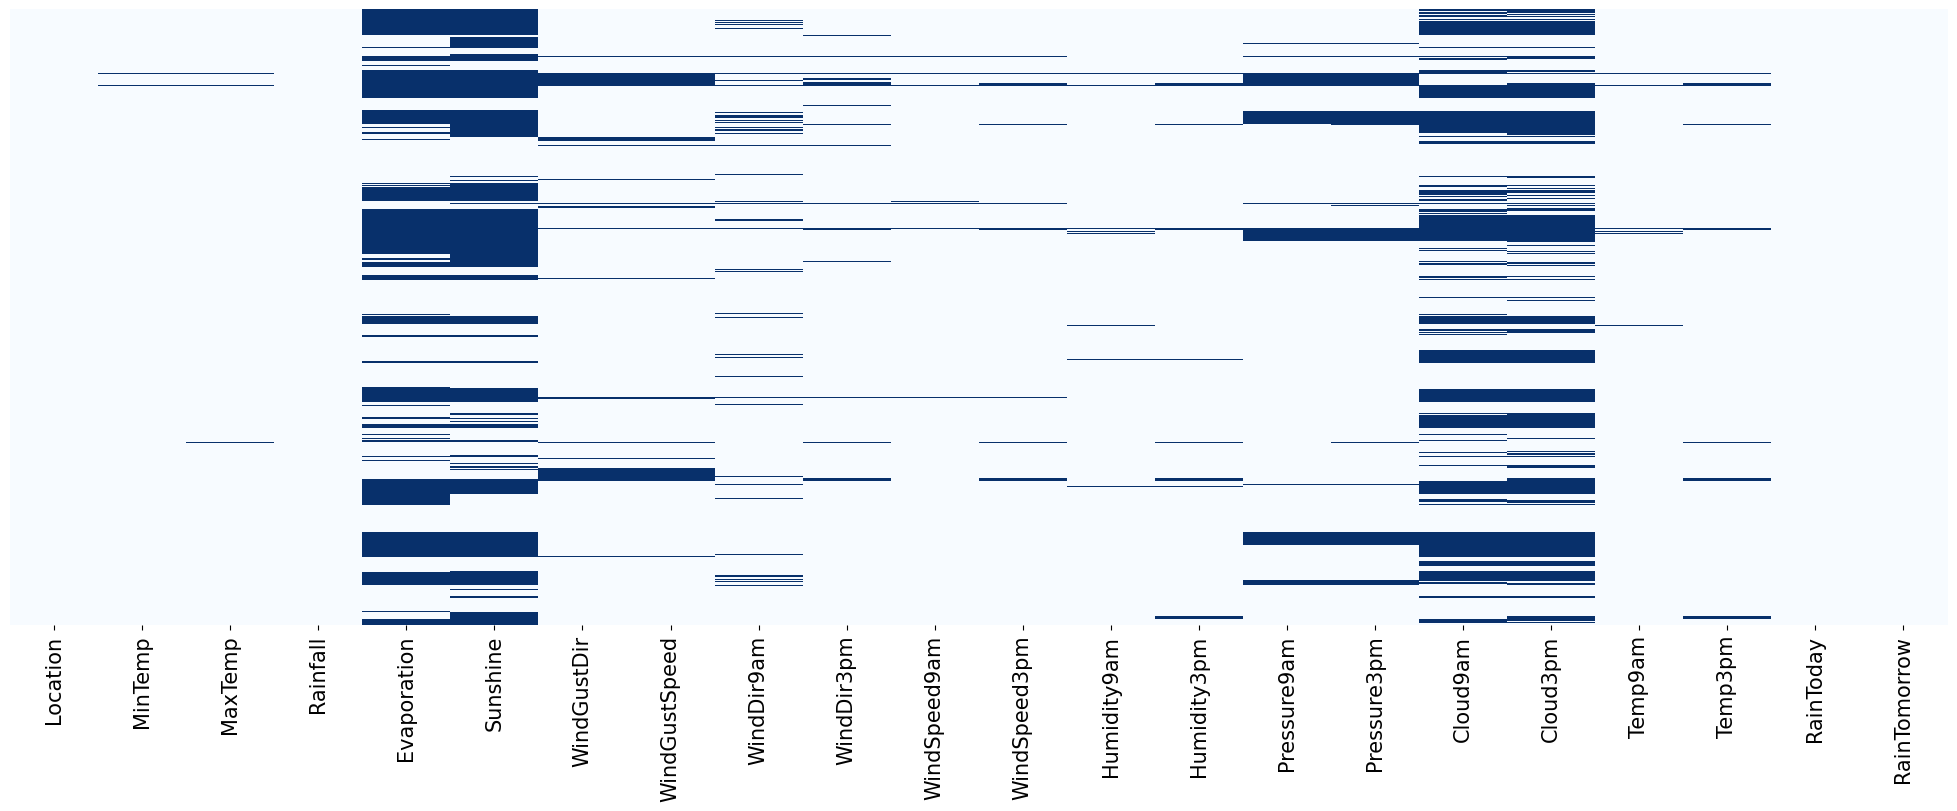

In [ ]:
plt.figure(figsize = (25,8))
sns.heatmap(raw_df.isnull(), cbar=False, cmap='Blues', yticklabels=False)
plt.xticks(fontsize = 15)
plt.ylabel(None)
plt.show()

***We will take care all the missing values in the Pipeline**

# Can work with the sample initially (Optional)

In [ ]:
use_sample = False

In [ ]:
sample_fraction = 0.1

In [ ]:
if use_sample:
  raw_df = raw_df.sample(frac=sample_fraction).copy()

# Create a Test Set

In [ ]:
train_set, test_set = train_test_split(raw_df, test_size=0.2,
                                      stratify=raw_df["RainTomorrow"],
                                      shuffle=True,
                                      random_state=42)

In [ ]:
train_proportions = train_set["RainTomorrow"].value_counts(normalize=True)
test_proportions = test_set["RainTomorrow"].value_counts(normalize=True)

print(train_proportions, "\n")
print(test_proportions, "\n")

# Compare the proportions:
print(train_proportions / test_proportions)

RainTomorrow
No     0.778379
Yes    0.221621
Name: proportion, dtype: float64 

RainTomorrow
No     0.778393
Yes    0.221607
Name: proportion, dtype: float64 

RainTomorrow
No     0.999981
Yes    1.000067
Name: proportion, dtype: float64


# Explore and Visualize the Training Set

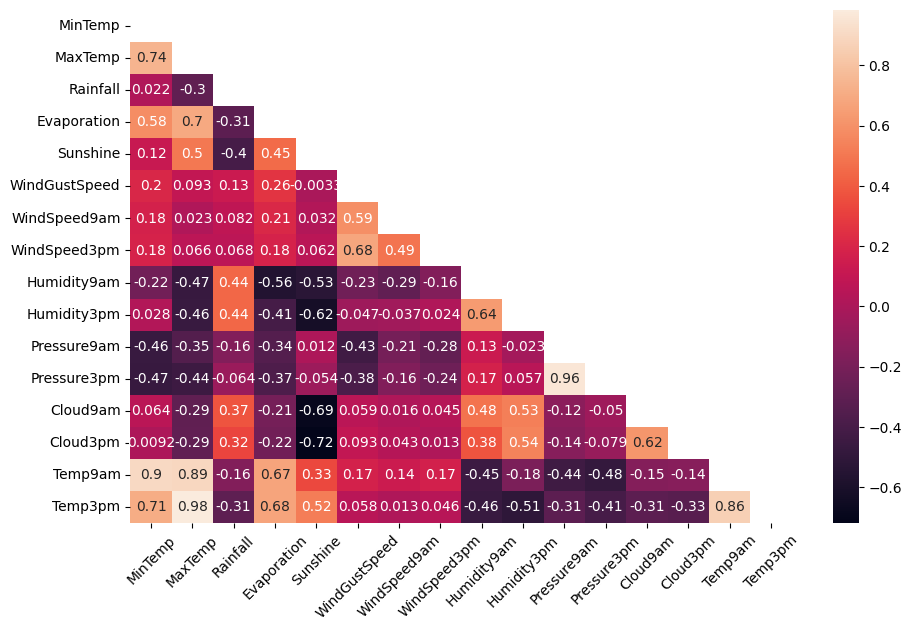

In [ ]:
corri = train_set[numerical_features].corr(method = 'spearman')
mask = np.triu(np.ones_like(corri, dtype=bool))
plt.figure(figsize=(16/1.5,10/1.5))
sns.heatmap(corri, annot=True, mask = mask)
plt.xticks(rotation=45)
plt.show()

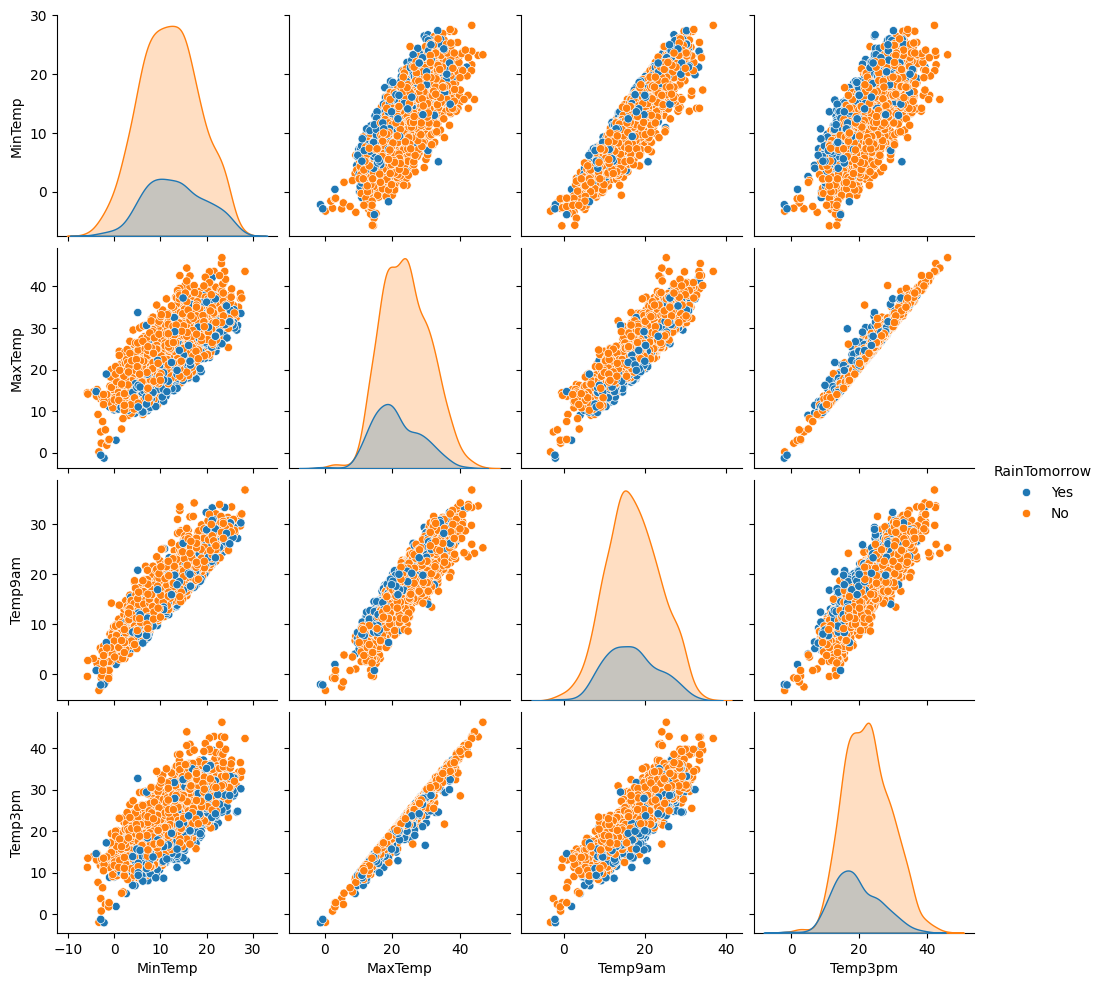

In [ ]:
tmp_cols = ["MinTemp", "MaxTemp", "Temp9am", "Temp3pm"]
sns.pairplot(data=train_set.sample(2000), vars=tmp_cols, hue="RainTomorrow")

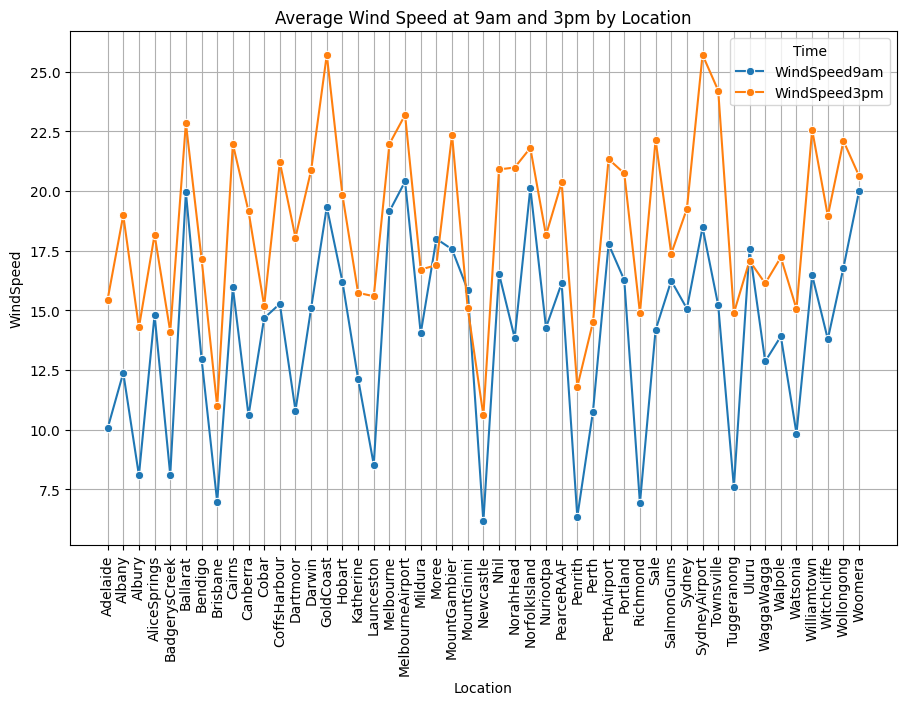

In [ ]:
plt.figure(figsize=(16/1.5,10/1.5))
windspeed_df = train_set.groupby(["Location"])[['WindSpeed9am', 'WindSpeed3pm']].mean()
windspeed_df = windspeed_df.reset_index()
windspeed_long = windspeed_df.melt(id_vars="Location",
                                    value_vars=["WindSpeed9am", "WindSpeed3pm"],
                                    var_name="Time", value_name="WindSpeed")

sns.lineplot(data=windspeed_long, x="Location", y="WindSpeed", hue="Time", marker='o')
plt.xticks(rotation=90)
plt.title("Average Wind Speed at 9am and 3pm by Location")
plt.grid(True)
plt.show()

# Prepare the Data

In [ ]:
X_train = train_set.drop("RainTomorrow", axis=1)
y_train = train_set.RainTomorrow

### Handling Categorical Missing Values (Demo)

In [ ]:
train_set_demo = train_set.copy()
df_cat = train_set_demo[categorical_features].dropna()
loc_cat = df_cat.groupby(['Location'])[categorical_features[1:-2]].agg(pd.Series.mode)
del df_cat
loc_cat.T

Location,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,...,ENE,NW,E,ENE,SE,N,WNW,SSE,S,SSE
WindDir9am,N,SE,ESE,SW,N,SSE,SW,SSE,NW,NE,...,SE,NW,E,E,NW,NE,WNW,SE,SW,SE
WindDir3pm,WSW,W,ESE,NNE,N,N,ENE,SE,WNW,SW,...,ENE,NW,E,WSW,SSE,SSW,ESE,SSE,NE,SSW


In [ ]:
for col in categorical_features[1:-2]:
  train_set_demo[col] = train_set_demo.apply(
      lambda row: loc_cat.loc[row["Location"], col]
      if pd.isnull(row[col]) and row["Location"] in loc_cat.index
      else row[col],
      axis=1
  )

In [ ]:
get_nan(train_set_demo[categorical_features]).loc[categorical_features[1:-2]]

,missing_percentage,total_missing
WindGustDir,4.221826,4755
WindDir9am,1.099184,1238
WindDir3pm,1.391294,1567


In [ ]:
len(train_set_demo.Location.unique()), len(loc_cat.index)
# This explains why there are still missing values

(49, 47)

In [ ]:
pendings = list(set(train_set_demo.Location.unique().tolist()) - set(loc_cat.index.tolist()))
print(pendings)

['Newcastle', 'Albany']


In [ ]:
modes = train_set_demo[categorical_features[1:-2]].apply(pd.Series.mode).to_dict("list")
modes = {col: modes[col][0] for col in modes}

for col in categorical_features[1:-2]:
    train_set_demo[col] = train_set_demo[col].fillna(modes[col])

In [ ]:
get_nan(train_set_demo[categorical_features])

,missing_percentage,total_missing
Location,0.0,0
WindGustDir,0.0,0
WindDir9am,0.0,0
WindDir3pm,0.0,0
RainToday,0.0,0
RainTomorrow,0.0,0


In [ ]:
del train_set_demo

### Handling Numerical Missing Values (Demo)

In [ ]:
train_set_demo = train_set.copy()

loc_num = train_set_demo.groupby(['Location'])[numerical_features].mean()

loc_num.fillna(train_set_demo[numerical_features].mean(), inplace=True)

# Iterate through the locations and fill NaN values in the original DataFrame with the location-specific means
for l in tqdm(train_set_demo.Location.unique()):
    indices = train_set_demo[train_set_demo['Location'] == l].index
    available_nan = get_nan(train_set_demo).index
    for col in available_nan:
        if col in numerical_features:
            train_set_demo.loc[indices, col] = train_set_demo.loc[indices, col].fillna(loc_num.loc[l, col])

# Keep only 'Location' and numeric columns in train_set_demo
train_set_demo = train_set_demo[['Location'] + numerical_features]


100%|██████████| 49/49 [00:05<00:00,  8.94it/s]


In [ ]:
get_nan(train_set_demo).T

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
missing_percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total_missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
del train_set_demo

## Pipelines

### Categorical

In [ ]:
class LocationBasedCategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols, location_col='Location'):
        self.categorical_cols = categorical_cols
        self.location_col = location_col
        self.global_modes = {}
        self.loc_modes = pd.DataFrame()

    def fit(self, X, y=None):
        df = X.copy()

        # Step 1: Compute global mode
        modes = df[self.categorical_cols].apply(pd.Series.mode).to_dict("list")
        self.global_modes = {col: modes[col][0] if modes[col] else None for col in modes}

        # Step 2: Compute location-based modes
        df_cat = df[[self.location_col] + self.categorical_cols].dropna()
        self.loc_modes = df_cat.groupby(self.location_col)[self.categorical_cols].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)

        return self

    def transform(self, X):
        df = X.copy()

        for col in tqdm(self.categorical_cols):
            # First step: location-based imputation
            def impute(row):
                loc = row[self.location_col]
                if pd.isnull(row[col]) and loc in self.loc_modes.index:
                    return self.loc_modes.loc[loc, col]
                else:
                    return row[col]

            df[col] = df.apply(impute, axis=1)

            # Second step: global mode imputation(just to clean up the remaining missing values)
            df[col] = df[col].fillna(self.global_modes[col])

        return df


In [ ]:
cat_cols_to_impute = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

cat_pipeline = make_pipeline(
    LocationBasedCategoricalImputer(cat_cols_to_impute, location_col='Location'),
    OneHotEncoder(handle_unknown="ignore"))

cat_pipeline

Pipeline(steps=[('locationbasedcategoricalimputer',
                 LocationBasedCategoricalImputer(categorical_cols=['WindGustDir',
                                                                   'WindDir9am',
                                                                   'WindDir3pm'])),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

#### Demo (Categorical)

In [ ]:
transformer_demo = train_set[categorical_features[:-1]].copy()

# Apply the pipeline to the dataframe
cat_pipeline.fit(transformer_demo)
transformed_data = cat_pipeline.transform(transformer_demo).toarray()
encoded_columns = cat_pipeline.named_steps['onehotencoder'].get_feature_names_out(input_features=transformer_demo.columns)

100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


In [ ]:
pd.DataFrame(transformed_data, columns=encoded_columns)

,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112627,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
del transformer_demo
del transformed_data
del encoded_columns

### Numerical

In [ ]:
class LocationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, location_col='Location'):
        self.numerical_features = numerical_features
        self.location_col = location_col
        self.loc_num_means_ = None
        self.global_means_ = None

    def fit(self, X, y=None):
        X = X.copy()
        self.loc_num_means_ = X.groupby(self.location_col)[self.numerical_features].mean()
        self.global_means_ = X[self.numerical_features].mean()
        self.loc_num_means_ = self.loc_num_means_.fillna(self.global_means_)
        return self

    def transform(self, X):
        X = X.copy()
        for l in tqdm(X[self.location_col].unique(), desc="Imputing by location"):
            indices = X[X[self.location_col] == l].index
            for col in self.numerical_features:
                if col in X.columns:
                    X.loc[indices, col] = X.loc[indices, col].fillna(self.loc_num_means_.loc[l, col])
        return X[self.numerical_features]

In [ ]:
num_pipeline = make_pipeline(
    LocationImputer(numerical_features=numerical_features, location_col='Location'),
    StandardScaler()
    )

num_pipeline

Pipeline(steps=[('locationimputer',
                 LocationImputer(numerical_features=['MinTemp', 'MaxTemp',
                                                     'Rainfall', 'Evaporation',
                                                     'Sunshine',
                                                     'WindGustSpeed',
                                                     'WindSpeed9am',
                                                     'WindSpeed3pm',
                                                     'Humidity9am',
                                                     'Humidity3pm',
                                                     'Pressure9am',
                                                     'Pressure3pm', 'Cloud9am',
                                                     'Cloud3pm', 'Temp9am',
                                                     'Temp3pm'])),
                ('standardscaler', StandardScaler())])

#### Demo

In [ ]:
tmp_num_df = train_set.copy()
transformed_data = num_pipeline.fit_transform(tmp_num_df)

Imputing by location: 100%|██████████| 49/49 [00:01<00:00, 29.06it/s]


In [ ]:
transformed_data

array([[ 1.75291378,  2.53798315, -0.27731464, ...,  1.6051405 ,
         2.09419819,  2.55938362],
       [-0.16936217, -1.52237172, -0.1116698 , ...,  1.6051405 ,
        -0.87053366, -1.44277149],
       [-1.09142949, -0.91823587, -0.06434271, ..., -0.03295435,
        -1.70004412, -1.45716773],
       ...,
       [-0.37252954, -0.229802  , -0.27731464, ..., -2.1323393 ,
        -0.64011408, -0.06073232],
       [ 0.3463704 , -0.14550398, -0.22998754, ..., -0.03295435,
        -0.10246841, -0.04633608],
       [ 0.12757477, -0.18765299, -0.27731464, ..., -0.03295435,
        -0.25608146, -0.01754359]])

### Preprocessing

In [ ]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features + ['Location']),
    ('cat', cat_pipeline, cat_cols_to_impute + ['Location'])
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('locationimputer',
                                                  LocationImputer(numerical_features=['MinTemp',
                                                                                      'MaxTemp',
                                                                                      'Rainfall',
                                                                                      'Evaporation',
                                                                                      'Sunshine',
                                                                                      'WindGustSpeed',
                                                                                      'WindSpeed9am',
                                                                                      'WindSpeed3pm',
                                                                                      'Humidity9am',
                                                                                      'Humidity3pm',
                                                                                      'Pressure9am',
                                                                                      'Pressure3pm',
                                                                                      'Cloud9am',
                                                                                      'Cloud3pm',
                                                                                      'Temp9am',
                                                                                      'Temp3pm'])),
                                                 ('standardscaler',
                                                  StandardScaler())])...
                                  'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                                  'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                                  'Location']),
                                ('cat',
                                 Pipeline(steps=[('locationbasedcategoricalimputer',
                                                  LocationBasedCategoricalImputer(categorical_cols=['WindGustDir',
                                                                                                    'WindDir9am',
                                                                                                    'WindDir3pm'])),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['WindGustDir', 'WindDir9am', 'WindDir3pm',
                                  'Location'])])

In [ ]:
X_train_demo = X_train.copy()
X_transformed_demo = preprocessor.fit_transform(X_train_demo)

X_transformed_demo

100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2252580 stored elements and shape (112629, 113)>

# Train Model

In [ ]:
y_train = y_train.map({'No': 0, 'Yes': 1})
y_train

,RainTomorrow
144971,0
104440,1
52420,0
137631,0
25368,0
...,...
17186,0
121644,0
120249,0
5964,1


### Logistic Regression

In [ ]:
logist_clf = make_pipeline(preprocessor, LogisticRegression())
logist_clf.fit(X_train, y_train)

100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('locationimputer',
                                                                   LocationImputer(numerical_features=['MinTemp',
                                                                                                       'MaxTemp',
                                                                                                       'Rainfall',
                                                                                                       'Evaporation',
                                                                                                       'Sunshine',
                                                                                                       'WindGustSpeed',
                                                                                                       'WindSpeed9am',
                                                                                                       'WindSpeed3pm',
                                                                                                       'Humidity9am',
                                                                                                       'Humidity3pm',
                                                                                                       'Pressure9am',
                                                                                                       'Pressure3pm',
                                                                                                       'Cloud9am',
                                                                                                       'Cloud3pm',
                                                                                                       'Temp9am',
                                                                                                       'Temp3pm'])),...
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm',
                                                   'Location']),
                                                 ('cat',
                                                  Pipeline(steps=[('locationbasedcategoricalimputer',
                                                                   LocationBasedCategoricalImputer(categorical_cols=['WindGustDir',
                                                                                                                     'WindDir9am',
                                                                                                                     'WindDir3pm'])),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['WindGustDir', 'WindDir9am',
                                                   'WindDir3pm',
                                                   'Location'])])),
                ('logisticregression', LogisticRegression())])

In [ ]:
cross_val_score(logist_clf, X_train, y_train, cv=3, scoring="accuracy")

100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


array([0.84918627, 0.84929281, 0.85003862])

In [ ]:
y_train_pred = cross_val_predict(logist_clf, X_train, y_train, cv=3)
y_train_pred

100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
confusion_matrix(y_train, y_train_pred)

array([[82968,  4700],
       [12250, 12711]])

In [ ]:
precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred)

(0.7300557119062662, 0.5092344056728496)

### SVC

In [ ]:
svc = make_pipeline(preprocessor, SVC())
svc.fit(X_train, y_train)

100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('locationimputer',
                                                                   LocationImputer(numerical_features=['MinTemp',
                                                                                                       'MaxTemp',
                                                                                                       'Rainfall',
                                                                                                       'Evaporation',
                                                                                                       'Sunshine',
                                                                                                       'WindGustSpeed',
                                                                                                       'WindSpeed9am',
                                                                                                       'WindSpeed3pm',
                                                                                                       'Humidity9am',
                                                                                                       'Humidity3pm',
                                                                                                       'Pressure9am',
                                                                                                       'Pressure3pm',
                                                                                                       'Cloud9am',
                                                                                                       'Cloud3pm',
                                                                                                       'Temp9am',
                                                                                                       'Temp3pm'])),...
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm',
                                                   'Location']),
                                                 ('cat',
                                                  Pipeline(steps=[('locationbasedcategoricalimputer',
                                                                   LocationBasedCategoricalImputer(categorical_cols=['WindGustDir',
                                                                                                                     'WindDir9am',
                                                                                                                     'WindDir3pm'])),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['WindGustDir', 'WindDir9am',
                                                   'WindDir3pm',
                                                   'Location'])])),
                ('svc', SVC())])

In [ ]:
y_train_pred = svc.predict(X_train)

100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


In [ ]:
confusion_matrix(y_train, y_train_pred)

array([[84993,  2675],
       [11189, 13772]])

In [ ]:
precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred)

(0.837356356782392, 0.5517407155162053)

### Decision Tree

In [ ]:
dt_clf = make_pipeline(preprocessor, SVC())
dt_clf.fit(X_train, y_train)

100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('locationimputer',
                                                                   LocationImputer(numerical_features=['MinTemp',
                                                                                                       'MaxTemp',
                                                                                                       'Rainfall',
                                                                                                       'Evaporation',
                                                                                                       'Sunshine',
                                                                                                       'WindGustSpeed',
                                                                                                       'WindSpeed9am',
                                                                                                       'WindSpeed3pm',
                                                                                                       'Humidity9am',
                                                                                                       'Humidity3pm',
                                                                                                       'Pressure9am',
                                                                                                       'Pressure3pm',
                                                                                                       'Cloud9am',
                                                                                                       'Cloud3pm',
                                                                                                       'Temp9am',
                                                                                                       'Temp3pm'])),...
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm',
                                                   'Location']),
                                                 ('cat',
                                                  Pipeline(steps=[('locationbasedcategoricalimputer',
                                                                   LocationBasedCategoricalImputer(categorical_cols=['WindGustDir',
                                                                                                                     'WindDir9am',
                                                                                                                     'WindDir3pm'])),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['WindGustDir', 'WindDir9am',
                                                   'WindDir3pm',
                                                   'Location'])])),
                ('svc', SVC())])

In [ ]:
y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=3)
y_train_pred

100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
confusion_matrix(y_train, y_train_pred)

array([[84993,  2675],
       [11189, 13772]])

In [ ]:
precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred)

(0.837356356782392, 0.5517407155162053)